# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


## Постановка задачи
Вы - NLP-инженер новостной аналитической платформы. Ваша система одновременно извлекает сущности из новостных текстов (NER, токен-уровень) и определяет набор прикладных событий и отношений в документе (CLS, документ-уровень). Это позволяет автоматически помечать важные факты в новостях (персоны, организации, даты) и формировать теги и инцидентные фильтры для быстрого поиска и аналитики.

Но есть проблема: текущий пайплайн раздельно выполняет NER и классификацию событий. В результате признаки дублируются, а вычислительные ресурсы используются неэффективно. 

Вы предположили, что совместное обучение (multi-task) повысит качество NER и/или стабильность детекции событий. Чтобы проверить гипотезу, вам предстоит построить компактный воспроизводимый эксперимент, который:

- **реализует объединённую encoder-модель, которая решает задачи NER и классификации событий**;
- делает качественные и количественные **выводы о взаимном влиянии задач**.

## Критерии успеха
- **token_f1 ≥ 0.5 и cls_micro_f1 ≥ 0.8**

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных

Публичный датасет NEREL в формате JSONL: train, dev, test. Этот датасет содержит тексты, сущности (строки с офсетами) и отношения/события, его можно скачать на huggingface:


- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/dev.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/test.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl
- https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl


**Целевой признак:**
- NER (классфикация токенов): train.jsonl\text -> train.jsonl\entities -> **ent_types.jsonl\type**
- Multi-label классификация текстов: train.jsonl\text -> **rel_types.jsonl\type**

## Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



## Инициализация

### Импорт библиотек

In [ ]:
import re
from collections import Counter
import os
import urllib.request
import json
import pandas as pd
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification
from bertviz import head_view
import torch
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader

### Установка главных параметров

In [115]:
K = 30 # TOP отношений

## Загрузка данных

In [116]:
files = ["data/train.jsonl",
        "data/dev.jsonl",
        "data/test.jsonl",
        "ent_types.jsonl",
        "rel_types.jsonl"]
if not os.path.exists ("data"):
    os.mkdir("data")
    
if not os.path.exists (files[0]):
    for f in files:
        urllib.request.urlretrieve( \
            f"https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/{f}", f)

In [117]:
def load_jsonl (path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

In [118]:
train_dataset = load_jsonl("data/train.jsonl")
test_dataset = load_jsonl("data/test.jsonl")
ent_types = load_jsonl("ent_types.jsonl")
rel_types = load_jsonl("rel_types.jsonl")

## 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [119]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [120]:
train_dataset[:3]

[{'id': 0,
  'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба от

In [121]:
def make_event_list(records, K=30):
    entities, relations = dict(), dict()
    text_lens, entities_lens = [], []

    for i, news in enumerate(records):
        for j, entity in enumerate(records[i]['entities']):
            parsed = parse_entity_line(entity)
            t = parsed['type']
            entities[t] = entities.get(t, 0) + 1
        for j, relation in enumerate(records[i]['relations']):
            parsed = parse_relation_line(relation)
            r = parsed['type']
            relations[r] = relations.get(r, 0) + 1
        text_lens.append ( len(records[i]['text'].split()) )
        entities_lens.append ( len(records[i]['entities']) )

    top_entities = sorted(entities.items(), key=lambda x: x[1], reverse=True)
    top_relations = sorted(relations.items(), key=lambda x: x[1], reverse=True)

    print (f"Всего уникальных сущностей {len(top_entities)}")
    print (f"Всего уникальных отношений {len(top_relations)}")
    top_entities = top_entities[:K]
    top_relations = top_relations[:K]
    
    return top_entities, top_relations, text_lens, entities_lens

records = train_dataset
top30_entities, top30_relations, text_lens, entities_per_doc = \
    make_event_list(records, K)

top30_relations_list = [x[0] for x in top30_relations]

Всего уникальных сущностей 29
Всего уникальных отношений 49


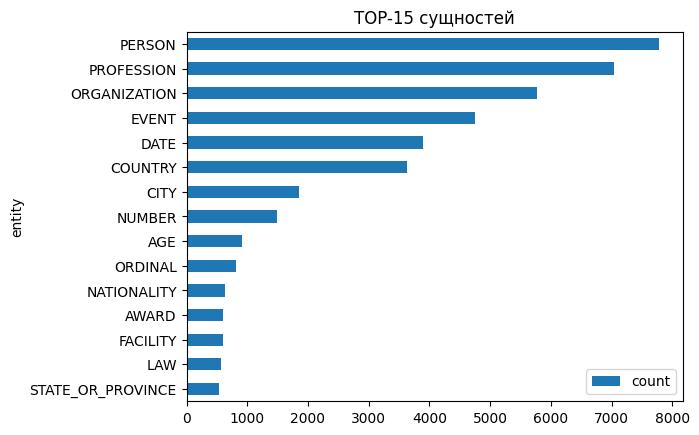

In [122]:
top_entities_df = pd.DataFrame(top30_entities[:15], columns=['entity', 'count'])
top_entities_df = top_entities_df.set_index('entity')
ax = top_entities_df.plot.barh(title="TOP-15 сущностей")
ax.invert_yaxis()

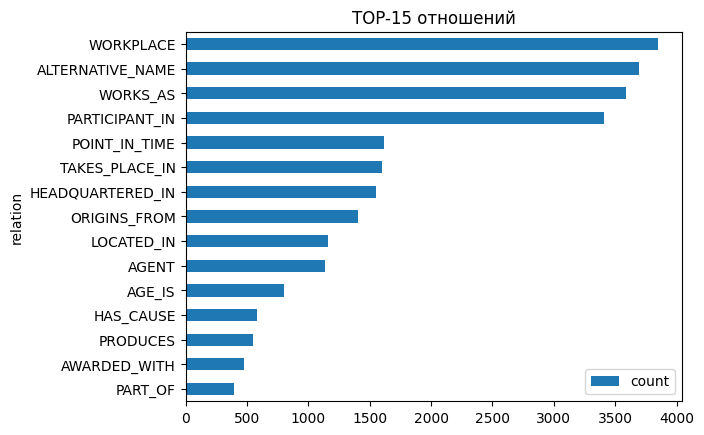

In [123]:
top_relations_df = pd.DataFrame(top30_relations[:15], columns=['relation', 'count'])
top_relations_df = top_relations_df.set_index('relation')
ax = top_relations_df.plot.barh(title="TOP-15 отношений")
ax.invert_yaxis()

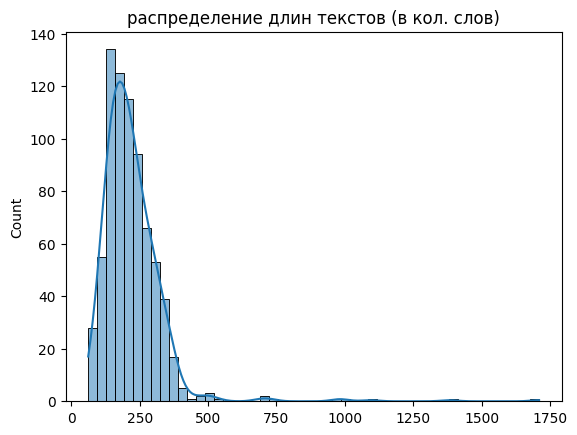

In [124]:
ax = sns.histplot(data=text_lens, bins=50, kde=True)
ax.set_title('распределение длин текстов (в кол. слов)');

In [125]:
pd.Series(text_lens).describe()

count     746.000000
mean      221.292225
std       119.721547
min        62.000000
25%       154.000000
50%       201.500000
75%       262.750000
max      1710.000000
dtype: float64

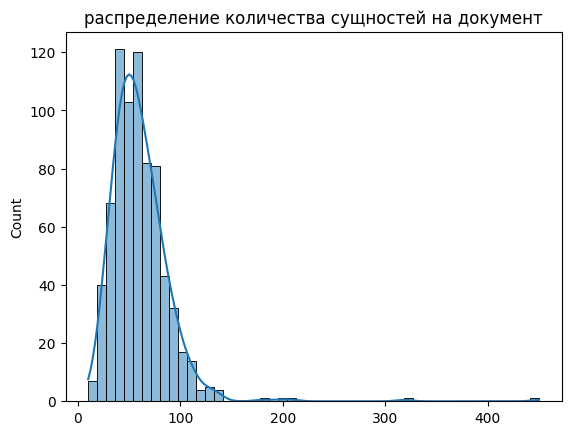

In [126]:
ax = sns.histplot(data=entities_per_doc, bins=50, kde=True)
ax.set_title('распределение количества сущностей на документ');

In [127]:
pd.Series(entities_per_doc).describe()

count    746.000000
mean      60.109920
std       29.857536
min       10.000000
25%       42.000000
50%       55.500000
75%       73.000000
max      450.000000
dtype: float64

### Выводы по EDA:
- Документы представляют собой новости.
- Сущности: страна, дата, организация, и т. д.
- Отношения: Организационные, локационные, временные и т. д.
- Всего уникальных сущностей 29
- Всего уникальных отношений 49
- График TOP-15 сущностей представлен выше (Person, Profession, Organization, Event, Date, ...)
- График TOP-15 отношений представлен выше (Workplace, Alternative_name, Works_as, ...)
- **Таким образом, наиболее частые новости - о работе людей и организаций, о бизнесе**
- медианная длина текста 201 слово, минимальная - 62, максимальная - 1710 - график распределения представлен выше, распределение похоже на нормальное со смещением влево
- медианная количество сущностей на документ - 56, минимальное - 10, максимальное - 450 - график распределения представлен выше, распределение похоже на нормальное со смещением влево

## 2. Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [128]:
top30_relations_list = [x[0] for x in top30_relations]
top30_relations_list

['WORKPLACE',
 'ALTERNATIVE_NAME',
 'WORKS_AS',
 'PARTICIPANT_IN',
 'POINT_IN_TIME',
 'TAKES_PLACE_IN',
 'HEADQUARTERED_IN',
 'ORIGINS_FROM',
 'LOCATED_IN',
 'AGENT',
 'AGE_IS',
 'HAS_CAUSE',
 'PRODUCES',
 'AWARDED_WITH',
 'PART_OF',
 'IDEOLOGY_OF',
 'MEMBER_OF',
 'CONVICTED_OF',
 'INANIMATE_INVOLVED',
 'SUBEVENT_OF',
 'SUBORDINATE_OF',
 'KNOWS',
 'MEDICAL_CONDITION',
 'PARENT_OF',
 'PLACE_RESIDES_IN',
 'OWNER_OF',
 'ABBREVIATION',
 'FOUNDED_BY',
 'ORGANIZES',
 'PENALIZED_AS']

In [129]:
len(records)

746

In [130]:
def whitespace_tokenize_with_offsets(text: str):
    tokens = []
    spans = []
    for m in re.finditer(r'\S+', text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

def build_examples_from_nerel(records: list[dict], event_list: list[str]) -> list[dict]:
    examples = []
    for rec in records:
        text = rec['text']
        tokens, token_spans = whitespace_tokenize_with_offsets(text)
        token_labels = ["O"] * len(tokens)

        parsed_entities = [parse_entity_line(entity) for entity in rec['entities']]
        for parsed in parsed_entities:
            is_token_1st = True
            span_start = parsed['start']
            span_end = parsed['end']
            entity_type = parsed['type']

            overlapping_idxs = []
            for i, (t_start, t_end) in enumerate(token_spans):
                if not (t_end <= span_start or t_start >= span_end):
                    overlapping_idxs.append(i)
            if not overlapping_idxs:
                continue
            for j, tok_idx in enumerate(overlapping_idxs):
                if token_labels[tok_idx] != "O":
                    continue
                if is_token_1st:
                    prefix = "B"
                    is_token_1st = False
                else:
                    prefix = "I"
                token_labels[tok_idx] = f"{prefix}-{entity_type}"

        cls_vec = [0] * len (event_list)
        parsed_relations = [parse_relation_line(entity) for entity in rec['relations']]
        for parsed in parsed_relations:
            rel_type = parsed['type']
            if rel_type in event_list:
                cls_vec [event_list.index(rel_type)] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec
        })
    return examples

In [131]:
train_examples = build_examples_from_nerel (train_dataset, top30_relations_list)

In [132]:
len(train_examples)

746

In [133]:
train_examples[:5]

[{'text': 'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмечает, что

## 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.

- Проверить shapes: input_ids, labels (с –100 для subword tokens), cls_labels.

In [134]:
unique_labels = set()
for ex in train_examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")
label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

for ex in train_examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]

full_ds = Dataset.from_list(train_examples)
split = full_ds.train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({"train": split["train"], "test": split["test"]})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
        num_rows: 671
    })
    test: Dataset({
        features: ['text', 'tokens', 'token_spans', 'tags', 'cls_vec'],
        num_rows: 75
    })
})


In [135]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [136]:
#def tokenize_and_align_labels (examples, tokenizer, label2id, max_length=128):
def tokenize_and_align_labels (examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128)
    labels = []
    for i, word_labels in enumerate(examples["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(word_labels[word_idx])
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx
        labels.append(label_ids)
    tokenized["labels"] = labels
    return tokenized

tokenized_dataset = dataset.map(
    tokenize_and_align_labels, batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags"] # cls_vec оставим 
)

Map: 100%|██████████| 75/75 [00:00<00:00, 348.84 examples/s]


In [137]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['cls_vec', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 671
    })
    test: Dataset({
        features: ['cls_vec', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 75
    })
})

In [138]:
tokenized_dataset["train"][0]

{'cls_vec': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1],
 'input_ids': [2,
  30167,
  17,
  8648,
  67842,
  24078,
  76673,
  35976,
  4608,
  21191,
  16,
  769,
  45267,
  778,
  71118,
  76673,
  35976,
  4608,
  34957,
  8648,
  67842,
  24078,
  34310,
  750,
  27057,
  35976,
  4608,
  21191,
  659,
  2681,
  669,
  735,
  314,
  9685,
  1600,
  2262,
  18,
  1041,
  35884,
  35976,
  4608,
  72149,
  314,
  30411,
  1781,
  2068,
  16,
  1150,
  991,
  42100,
  314,
  31498,
  314,
  30718,
  6349,
  3860,
  17,
  67842,
  83762,
  314,
  5277,
  329,
  72538,
  761,
  18,
  30167,
  17,
  8648,
  16,
  11749,
  11318,
  36463,
  314,
  728,
  1,
  677,
  3417,
  16,
  12323,
  1464,
  43278,
  54088,
  314,
  5277,
  329,
  43577,
  864,
  314,
  68157,
  629,
  18868,
  12699,
  2264,
  18,
  40350,
  1610,
  36220,
  13549,
  82473,
  656,
  320,
  70300,
  871,
  28198,


In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)
print("Готово. Примеры для обучения:", len(tokenized_dataset["train"]))

Готово. Примеры для обучения: 671


## 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [139]:
attention_model = AutoModel.from_pretrained(
    "cointegrated/rubert-tiny2", 
    output_attentions=True
)

## 5. Training / Validation



## 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


## Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!